In [ ]:
from google.colab import userdata

In [ ]:
import sys
import os
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
code_path = "/content/drive/MyDrive/uii/internships/intern_karate/uii_karate_internship_code"
#sys.path.append(os.path.dirname(code_path))


In [ ]:
#!git config --global user.email "paul.khimyack@gmail.com"
#!git config --global user.name "pauchai"


#!git clone https://github.com/pauchai/uii_karate_internship_code.git {code_path}

%cd {code_path}
#!git remote set-url origin https://{userdata.get('colab2_git')}@github.com/pauchai/uii_karate_internship_code.git

#!git status
#!git add src/embedder/operations.py src/utils/misc_enums.py
#!git diff
#!git commit -a -m "correct importing "
#!git push origin main
%cd /content


In [ ]:
!apt-get -q install davfs2

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libneon27
The following NEW packages will be installed:
  davfs2 libneon27
0 upgraded, 2 newly installed, 0 to remove and 15 not upgraded.
Need to get 258 kB of archives.
After this operation, 627 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libneon27 amd64 0.32.2-1 [102 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 davfs2 amd64 1.6.1-1 [155 kB]
Fetched 258 kB in 0s (2,352 kB/s)
Preconfiguring packages ...
Selecting previously unselected package libneon27:amd64.
(Reading database ... 120899 files and directories currently installed.)
Preparing to unpack .../libneon27_0.32.2-1_amd64.deb ...
Unpacking libneon27:amd64 (0.32.2-1) ...
Selecting previously unselected package davfs2.
Preparing to unpack .../davfs2_1.6.1-1_amd64.deb ...
Unpacking davfs2 (1.6.1-1) ...
Setting up libneon

In [ ]:
!mkdir -p /content/yandexdisk
!mount -t davfs https://webdav.yandex.ru /content/yandexdisk

Please enter the username to authenticate with server
https://webdav.yandex.ru or hit enter for none.
  Username: paul.khimyack
Please enter the password to authenticate user paul.khimyack with server
https://webdav.yandex.ru or hit enter for none.
  Password:  


нужен для получения списка CONNECTIONS

In [ ]:
!pip -q install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 33.2 MB/s eta 0:00:00


In [ ]:
import cv2
import tqdm
import os

from mediapipe.python.solutions import drawing_utils as mp_drawing
from mediapipe.framework.formats import landmark_pb2
from mediapipe import solutions
import pandas as pd
import json
import enum
from typing import Union
import numpy as np





In [ ]:
class PoseVisualizer(object):

  def __call__(self,
               frame,
               detection_result
               ):
        return self._draw_landmarks_on_image(frame, detection_result)



  def _draw_landmarks_on_image(self, rgb_image, detection_result):
    pose_landmarks_list = detection_result.pose_landmarks
    annotated_image = np.copy(rgb_image)

    # Loop through the detected poses to visualize.
    for idx in range(len(pose_landmarks_list)):
      pose_landmarks = pose_landmarks_list[idx]

      # Draw the pose landmarks.
      pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
      pose_landmarks_proto.landmark.extend([
        landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
      ])
      solutions.drawing_utils.draw_landmarks(
        annotated_image,
        pose_landmarks_proto,
        solutions.pose.POSE_CONNECTIONS,
        solutions.drawing_styles.get_default_pose_landmarks_style())
    return annotated_image

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import enum

In [ ]:
def show_image(img):
  plt.imshow(img)
  plt.show()

In [ ]:
CFG_DATASET_DIR = "/content/yandexdisk/uii/internship/KARATE_2step_s/dataset"
CFG_DATASET_VIDEOS_DIR = "/content/yandexdisk/uii/internship/KARATE_2step_s/dataset/videos/"
CFG_DATASET_FILES_INDICES = "/content/yandexdisk/uii/internship/KARATE_2step_s/dataset/single_hit.xlsx"
CFG_DATASET_FRAMES_LANDAMRKS = "/content/yandexdisk/uii/internship/KARATE_2step_s/dataset/frames_mediapipe_landmarks_file_id0056.xlsx"


In [ ]:
class Hits(enum.Enum):
  UNKNOWN_HIT = 0
  GEDAN_BARAY = 1
  GYAKU_DZUKY = 2
  KIDZAMI_DSUKI = 3
  MAVASHI_GERI = 4
  MAVASHI_DZUKI = 5
  MAY_GERI_KEAGE = 6
  SOTO_UKE = 7
  URAKEN_UCHI = 8
  URA_MAVASHI_GERI = 9
  UCHI_UKE = 10

In [ ]:
class VideoDataset():
  df_files = None
  df_frames = None


  def __init__(self, df_files, df_frames, dataset_dir):
    self.df_files = df_files
    self.df_frames = df_frames
    self.file_id_to_name = self.df_files.set_index('file_id')['file_name'].to_dict()

    self.dataset_dir = dataset_dir
    self.video_dir = os.path.join(self.dataset_dir, "videos")

  def get_files(self):
    return self.df_files["file_name"].values

  def get_file_data_by_id(self, file_id):
    return self.df_files[self.df_files['file_id'] == file_id].to_dict(orient="records")[0]

  def file_name_by_id(self, file_id, fool_path = True):
    file_name = self.file_id_to_name.get(file_id, None)
    if fool_path:
      return os.path.join(self.video_dir, file_name)
    else:
      return file_name



In [ ]:
class LandmarkProxy:
    def __init__(self, x, y, z, visibility, presence):
        self.x = x
        self.y = y
        self.z = z
        self.visibility = visibility
        self.presence = presence


    def __str__(self) -> str:
        return f"{self.x}, {self.y}, {self.z}, {self.visibility}, {self.presence}"

class DetectionResultProxy:
    def __init__(self, pose_landmarks):
        self.pose_landmarks = pose_landmarks

    @classmethod
    def _convert_for_mediapipe(cls, landmarks_data):
        pose_landmarks = []
        for landmark_info in landmarks_data:
            landmark = LandmarkProxy(x=landmark_info[0], y=landmark_info[1], z=landmark_info[2], visibility=landmark_info[3], presence=landmark_info[4])
            pose_landmarks.append(landmark)
        return cls([pose_landmarks])

    def __str__(self) -> str:
      # Convert pose_landmarks to a readable string
        landmarks_str = ", ".join(str(landmark) for landmark in self.pose_landmarks[0])

        return f"DetectionResultProxy: [{landmarks_str}]"


In [ ]:
pose_visualizer = PoseVisualizer()
video_dataset = VideoDataset(
    pd.read_excel(CFG_DATASET_FILES_INDICES, index_col=0),
    pd.read_excel(CFG_DATASET_FRAMES_LANDAMRKS, index_col=0),
    dataset_dir = CFG_DATASET_DIR
    )
#pose_embedder = DubrovinaEmbedder()


In [ ]:
#pose_embedder = FullBodyPoseEmbedder(torso_size_multiplier=1)
from uii_karate_internship_code.src.embedder.dubrovina import DubrovinaEmbedder
from uii_karate_internship_code.src.embedder.base import FullBodyPoseEmbedder

pose_embedder = DubrovinaEmbedder()

embeddings_list = []
for idx, row in video_dataset.df_frames.iterrows():

  landmarks_data = row['landmarks']
  pose_landmarks = DetectionResultProxy._convert_for_mediapipe(json.loads(landmarks_data)).pose_landmarks[0]
  frame_height, frame_width = 1, 1
  pose_landmarks = np.array([
        [lmk.x * frame_width, lmk.y * frame_height, lmk.z * frame_width] for lmk in pose_landmarks
      ], dtype=np.float32)
  assert pose_landmarks.shape == (33, 3), 'Unexpected landmarks shape: {}'.format(pose_landmarks.shape)
  embeddings_list.append(pose_embedder(pose_landmarks))


In [ ]:
embeddings_list = np.array(embeddings_list)
embeddings_list_diff = np.diff(embeddings_list, axis = 0)
embeddings_list_diff2 = np.diff(embeddings_list_diff, axis = 0)

In [ ]:
embeddings_list.shape

(651, 67)

In [ ]:
for idx, name in enumerate(pose_embedder.get_info()):
  print(idx, ":", name)

0 : Distance  between RIGHT_HIP and RIGHT_ANKLE
1 : Distance  between RIGHT_HIP and RIGHT_KNEE
2 : Distance  between RIGHT_KNEE and RIGHT_ANKLE
3 : Distance  between RIGHT_SHOULDER and RIGHT_WRIST
4 : Distance  between RIGHT_SHOULDER and RIGHT_ELBOW
5 : Distance  between RIGHT_ELBOW and RIGHT_WRIST
6 : Distance  between LEFT_HIP and LEFT_ANKLE
7 : Distance  between LEFT_HIP and LEFT_KNEE
8 : Distance  between LEFT_KNEE and LEFT_ANKLE
9 : Distance  between LEFT_SHOULDER and LEFT_WRIST
10 : Distance  between LEFT_SHOULDER and LEFT_ELBOW
11 : Distance  between LEFT_ELBOW and LEFT_WRIST
12 : Distance  between LEFT_ELBOW and RIGHT_ELBOW
13 : Distance  between LEFT_WRIST and RIGHT_WRIST
14 : Distance  between LEFT_KNEE and RIGHT_KNEE
15 : Distance  between LEFT_ANKLE and RIGHT_ANKLE
16 : Distance  between RIGHT_ELBOW and RIGHT_KNEE
17 : Distance  between LEFT_ELBOW and LEFT_KNEE
18 : Distance  between RIGHT_ELBOW and LEFT_KNEE
19 : Distance  between LEFT_ELBOW and RIGHT_KNEE
20 : Distance  b

In [ ]:
from scipy.signal import find_peaks
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def show_vectors(embeddings_list, embedder,  idxs = None, height = None, width = None, prominance = None, distance = None, threshold = None):
  x = np.arange(embeddings_list.shape[0])
  plt.figure(figsize=(10,6))

  extrema_sets = []
  valleys_sets = []

  if idxs is None:
    idxs = list(range(embeddings_list.shape[1]))
  peaks = []
  for i in idxs:
    y = embeddings_list[:,i]

    extrema, _ = find_peaks(y, height=height, width=width, distance=distance, prominence=prominance, threshold=threshold)
    #valleys, _ = find_peaks(-y, prominence=prominence_threshold)

    plt.plot(x[extrema], y[extrema], 'rx', label='Extrema')
    #plt.plot(x[valleys], y[valleys], 'rx', label='Valleys')

    extrema_sets.append(extrema)
   # valleys_sets.append(valleys)


    plt.plot(x,y, label=f'{i}-{embedder.get_info()[i]}')
    plt.title(f"{i} {embedder.get_info()[i]}")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()


  #plt.legend()



  return extrema_sets#, valleys_sets

In [ ]:
 if peak_level is not None:

 peaks = [peak for peak in peaks if y[peak] > peak_level]
      peaks_sets.append(peaks)
      plt.plot(x[peaks], y[peaks], 'rx', label='Peaks')
     '''

In [ ]:
peaks_sets

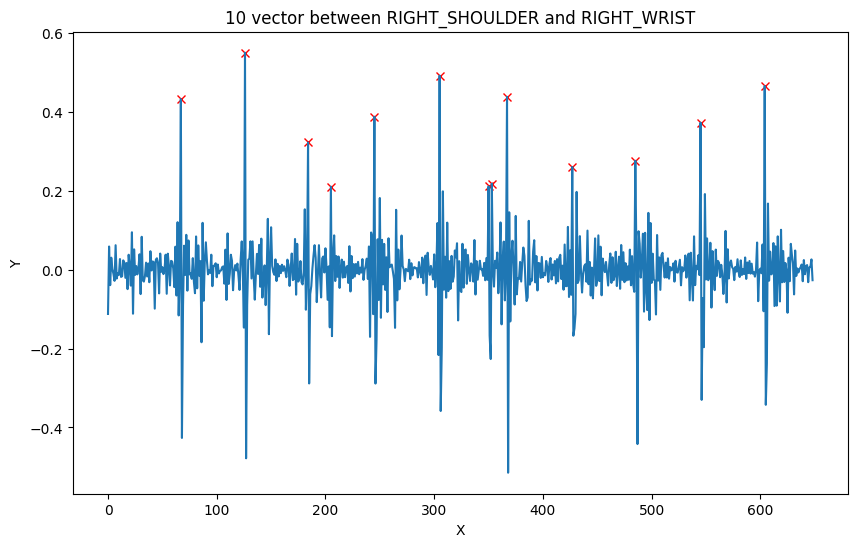

In [ ]:
peaks_sets = show_vectors(np.sum(np.array(embeddings_list_diff2), axis = -1),
    pose_embedder,

    [10],
    #prominance = 0.4,
    height = 0.2,
    #width = 0.5,
    #distance = 20,
    #threshold = 0.2,
    )


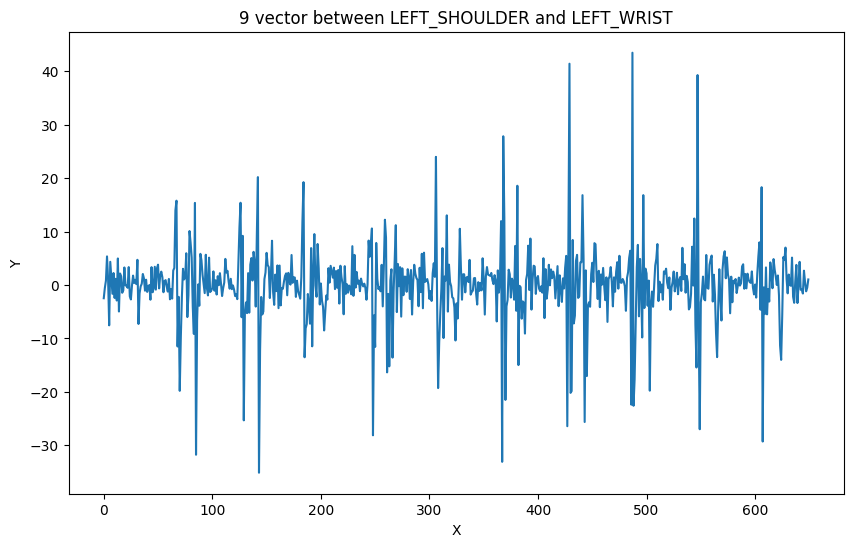

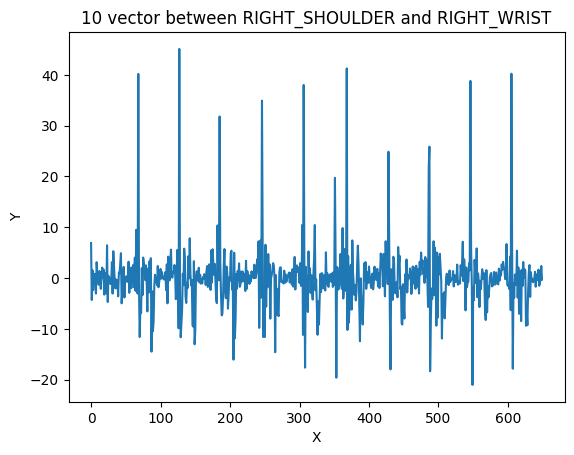

In [ ]:
embeddings = np.sum(embeddings_list_diff, axis = -1) * 100
peaks = show_vectors(
    embeddings , pose_embedder, [9, 10],
    peak_level = 10
             )

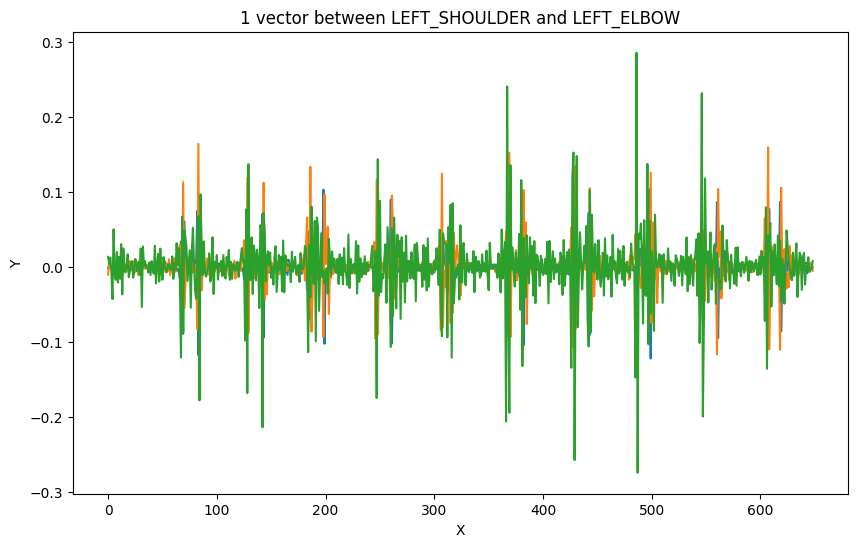

[]

In [ ]:
show_vectors(embeddings_list_diff2, pose_embedder, [1])

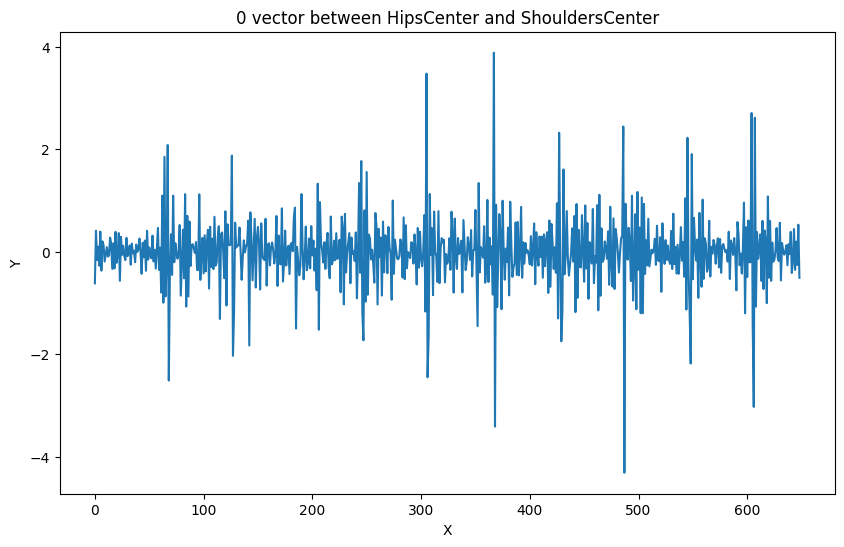

[]

In [ ]:
show_vectors(np.sum(embeddings_list_diff2, axis = (1,2), keepdims = True), pose_embedder)

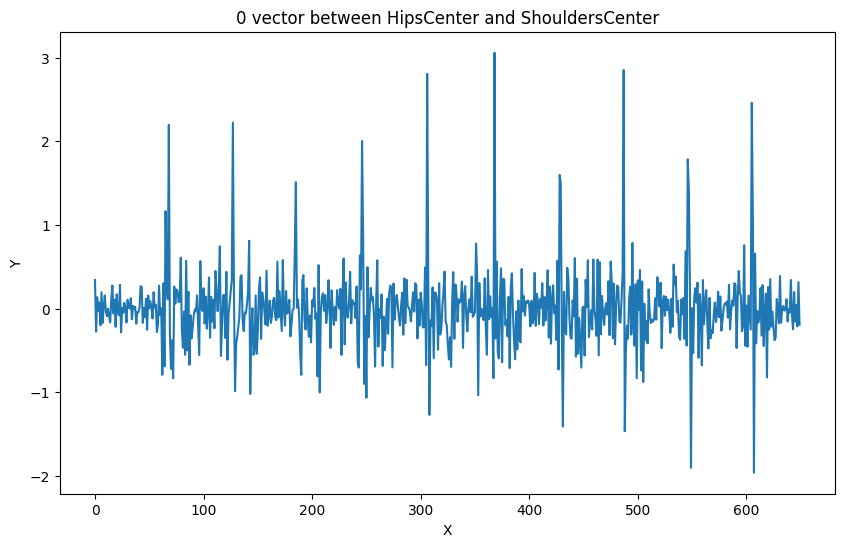

[]

In [ ]:
show_vectors(np.sum(embeddings_list_diff, axis = (1,2), keepdims = True), pose_embedder, [0])

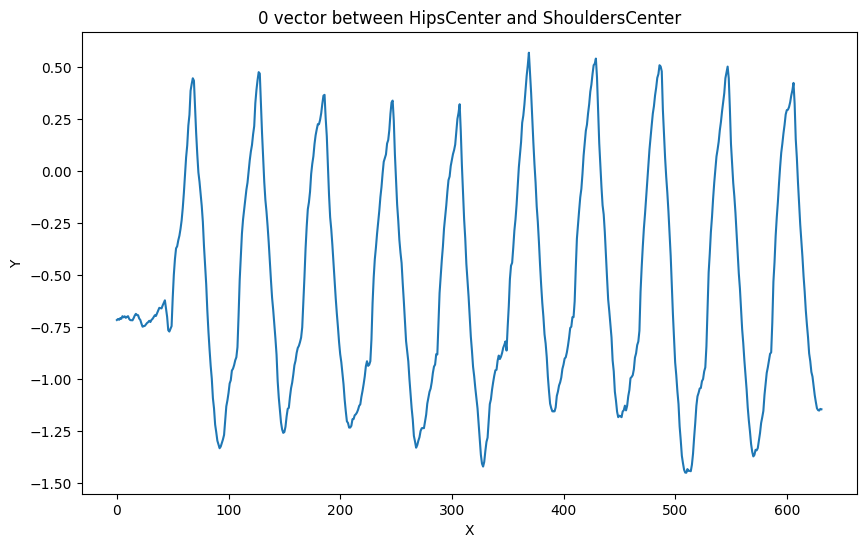

[]

In [ ]:
data = np.sum(embeddings_list, axis = (1,2) , keepdims = True)
window_size = 20
smoothed_array = np.apply_along_axis(lambda x: moving_average(x, window_size), axis=0, arr=data)
show_vectors(smoothed_array, pose_embedder)

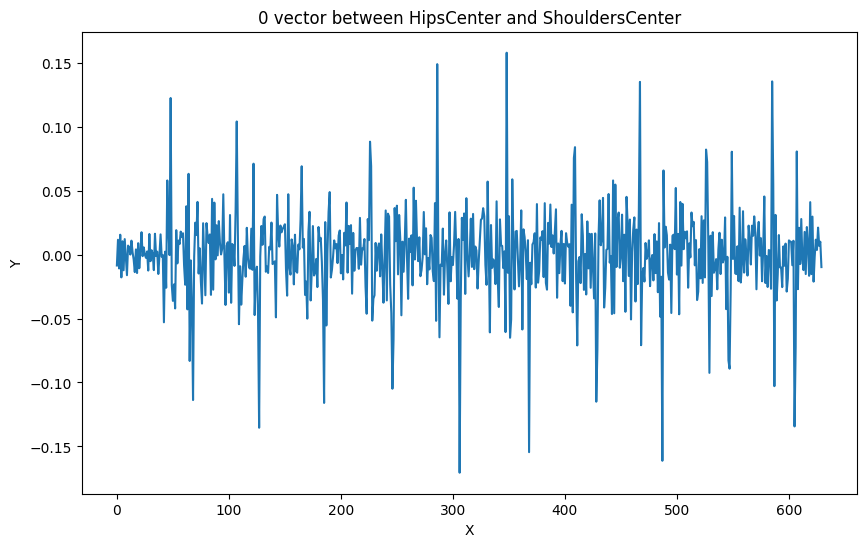

[]

In [ ]:
data = np.diff(np.diff(smoothed_array, axis = 0), axis = 0)
show_vectors(data, pose_embedder)

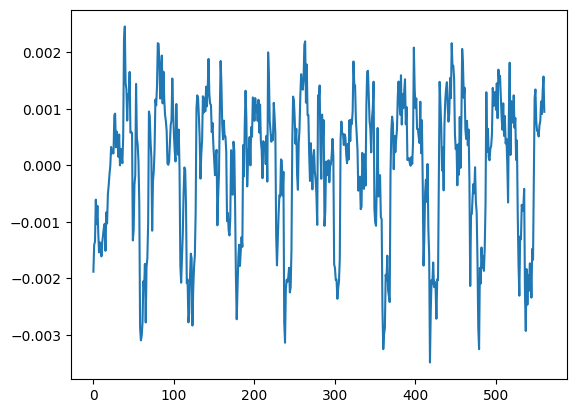

In [ ]:
#data = np.array(embeddings_list)
data = np.diff(np.diff(data_0 ))
window_size = 70
flat_array = data.reshape(data.shape[0], -1)
smoothed_array = np.apply_along_axis(lambda x: moving_average(x, window_size), axis=0, arr=data)
x = np.arange(smoothed_array.shape[0])
y = smoothed_array
plt.plot(x,y)


#Размечаем по пикам

In [ ]:
!pip install pysrt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.4/104.4 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pysrt: filename=pysrt-1.1.2-py3-none-any.whl size=13442 sha256=a02c62110c4023d82e7086e93b3559d99ce0ea24ee04455ef447f28e05bec1e9
  Stored in directory: /root/.cache/pip/wheels/30/7f/e8/55de9a9b07302d9e7fe47c27910e3bea0c48536153e74bd7e6
Successfully built pysrt


In [ ]:
import pysrt

def generate_subtitles(text, output_filename='subtitles.srt'):
    subs = pysrt.SubRipFile()

    # Split the text into words and create subtitles
    start_time = pysrt.SubRipItem(index=1, start="00:00:00,000")
    for i, word in enumerate(text.split()):
        end_time = start_time.start + pysrt.timedelta(seconds=len(word) / 2)  # Adjust as needed

        subtitle = pysrt.SubRipItem(
            index=i + 2,
            start=start_time.end,
            end=end_time,
            text=word
        )

        subs.append(subtitle)
        start_time = subtitle

    subs.save(output_filename, encoding='utf-8')
    print(f"Subtitles generated and saved to {output_filename}")


In [ ]:
print(CFG_DATASET_FRAMES_LANDAMRKS)

/content/yandexdisk/uii/internship/KARATE_2step_s/dataset/frames_mediapipe_landmarks_file_id0056.xlsx


In [ ]:
file_data = video_dataset.get_file_data_by_id(56)
file_name = video_dataset.file_name_by_id(56)

In [ ]:
file_data

{'file_id': 56,
 'file_name': 'single_hit/correct/МАВАШИ  ДЗУКИ (КРУГОВОЙ УДАР ЗАДНЕЙ РУКОЙ)/С БОКУ/Андрей МАВАШИ ДЗУКИ (2).mp4',
 'correct': True,
 'train': True,
 'hit_id': 5.0,
 'hit_name': 'МАВАШИ  ДЗУКИ',
 'camera': 'side',
 'video_fps': 30,
 'video_width': 1920,
 'video_height': 1080,
 'video_frames_count': 651}

In [ ]:
import pysrt
import datetime

In [ ]:
651 / 30

21.7

In [ ]:

# Create a list to store the tuples
result_list = []

# Create a dictionary to store the data
result_dict = {}

# Iterate over each set of peaks
for set_idx, peaks_set in enumerate(peaks_sets):
    # Sort the peaks in ascending order
    sorted_peaks = sorted(peaks_set)

    # Update the result_dict with peaks and set indices
    for peak in sorted_peaks:
        if peak not in result_dict:
            result_dict[peak] = [set_idx]
        else:
            result_dict[peak].append(set_idx)

# Convert the result_dict to the desired format
result_list = list(result_dict.items())

# Print the resulting list of tuples
print(result_list)

[(67, [0, 1]), (69, [0]), (84, [0, 1]), (128, [0]), (142, [0, 1]), (184, [0, 1]), (247, [0]), (260, [0, 1]), (307, [0]), (367, [0]), (369, [0, 1]), (381, [0, 1]), (426, [0, 1]), (429, [0]), (431, [0]), (443, [0, 1]), (487, [0]), (496, [0, 1]), (499, [0, 1]), (546, [0, 1]), (549, [0]), (560, [0, 1]), (606, [0]), (126, [1]), (191, [1]), (245, [1]), (257, [1]), (265, [1]), (305, [1]), (312, [1]), (316, [1]), (366, [1]), (428, [1]), (441, [1]), (486, [1]), (493, [1]), (604, [1]), (619, [1])]


In [ ]:
sub_start_frame = 0
sub_end_frame = 0
subs = pysrt.SubRipFile()
output_file = ""
start_subtitle = pysrt.SubRipItem(index = 1 , text = "начало", start = "00:00:00, 000")
i = 0
start_time = "00:00:00, 000"
for (peak, sets) in result_list:

  seconds_offset = int(peak) / file_data['video_fps']
  delta = datetime.timedelta(seconds=seconds_offset)
  end_time = start_subtitle.start + pysrt.srttime.SubRipTime(milliseconds=int(delta.total_seconds() * 1000))

  sets_str = ",".join(map(str, sets))
  subtitle = pysrt.SubRipItem(
      index = i,
      start = start_time,
      end = end_time,
      text = f"перед кадр {peak}  график {sets_str} "
  )
  i +=1
  subs.append(subtitle)
  start_time  = end_time
print(subs)
subs.save(
    os.path.splitext(file_name)[0] + ".srt"
    , encoding='utf-8')




[<pysrt.srtitem.SubRipItem object at 0x7c233cc2e1a0>, <pysrt.srtitem.SubRipItem object at 0x7c233cc2f100>, <pysrt.srtitem.SubRipItem object at 0x7c233cc2c370>, <pysrt.srtitem.SubRipItem object at 0x7c233cc2d510>, <pysrt.srtitem.SubRipItem object at 0x7c233cc2f1f0>, <pysrt.srtitem.SubRipItem object at 0x7c233cc2c4f0>, <pysrt.srtitem.SubRipItem object at 0x7c233cc2f700>, <pysrt.srtitem.SubRipItem object at 0x7c233cc2e1d0>, <pysrt.srtitem.SubRipItem object at 0x7c2338fd9930>, <pysrt.srtitem.SubRipItem object at 0x7c2338fd86d0>, <pysrt.srtitem.SubRipItem object at 0x7c2338fda8f0>, <pysrt.srtitem.SubRipItem object at 0x7c2338fd9990>, <pysrt.srtitem.SubRipItem object at 0x7c2338fdbcd0>, <pysrt.srtitem.SubRipItem object at 0x7c2338fdaec0>, <pysrt.srtitem.SubRipItem object at 0x7c2338fdad10>, <pysrt.srtitem.SubRipItem object at 0x7c2338fdb0d0>, <pysrt.srtitem.SubRipItem object at 0x7c2338fda6e0>, <pysrt.srtitem.SubRipItem object at 0x7c2338fda200>, <pysrt.srtitem.SubRipItem object at 0x7c2338f

In [ ]:
os.path.splitext(file_name)

('/content/yandexdisk/uii/internship/KARATE_2step_s/dataset/videos/single_hit/correct/МАВАШИ  ДЗУКИ (КРУГОВОЙ УДАР ЗАДНЕЙ РУКОЙ)/С БОКУ/Андрей МАВАШИ ДЗУКИ (2)',
 '.mp4')

In [ ]:
os.path.splitext(file_name)[0] + ".srt"

'/content/yandexdisk/uii/internship/KARATE_2step_s/dataset/videos/single_hit/correct/МАВАШИ  ДЗУКИ (КРУГОВОЙ УДАР ЗАДНЕЙ РУКОЙ)/С БОКУ/Андрей МАВАШИ ДЗУКИ (2).srt'

In [ ]:
subs.save(
    os.path.splitext(file_name)[0] + ".srt"
    , encoding='utf-8')